In [1]:
import tensorflow as tf
from matplotlib import pyplot

from util import define_flags, flags, pool_size
define_flags()
from provider import get_input, charsets
from model import foward

# build graph with simple tensor

In [2]:
image_input_tensor = tf.placeholder(tf.float32, shape=[flags.FLAGS.image_height, None, 3], name='image_input')

shape = tf.shape(image_input_tensor)
image_width_tensor = shape[1]
images_tensor = tf.expand_dims(image_input_tensor, 0)
image_widths_tensor = tf.expand_dims(image_width_tensor, 0)

logprob = foward(images=images_tensor, is_training=False)
seq_len_inputs = tf.divide(image_widths_tensor, pool_size, name='seq_len_input_op')
sparse_code_pred, log_probability = \
    tf.nn.ctc_greedy_decoder(logprob, sequence_length=tf.cast(seq_len_inputs, tf.int32))
sparse_code_pred = sparse_code_pred[0]

INFO:tensorflow:cnn_net shape: (1, 4, ?, 512)
INFO:tensorflow:after reshape cnn, shape: (1, ?, 2048)
INFO:tensorflow:after lstm shape: (1, ?, 512)
INFO:tensorflow:fc_out shape: (1, ?, 37)
INFO:tensorflow:lstm_out shape: (1, ?, 37)


# create session

In [3]:
sess = tf.InteractiveSession()

# restore tensor from checkpoint

In [4]:
logdir = 'logs/'
sess.run(tf.global_variables_initializer())
ckpt = tf.train.latest_checkpoint(logdir)

saver = tf.train.Saver()
saver.restore(sess, ckpt)

INFO:tensorflow:Restoring parameters from logs/model.ckpt-38699


# generate fake image && infer

label text: ylkq1wgns


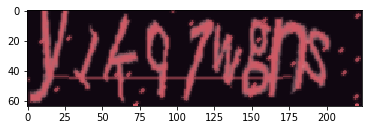

predict result: ylkq1wgns


In [5]:
images, image_widths, labels = sess.run(get_input())
labels = sess.run(tf.sparse_to_dense(labels.indices, labels.dense_shape, labels.values, default_value=-1))
labels = [''.join([charsets[i] for i in l if i != -1]) for l in labels]

label = labels[0]
image = images[0]

print('label text: %s' % label)
pyplot.imshow(image)
pyplot.show()

sparse_pred = sess.run(sparse_code_pred, feed_dict={image_input_tensor: image})
sparse_pred_values = ''.join([charsets[v] for v in sparse_pred.values])
print('predict result: %s' % sparse_pred_values)